In [ ]:
!git clone https://github.com/chrisyu-uiuc/revisit-deepcoxmixtures-cs598-uiuc
#ref : https://github.com/autonlab/auton-survival/blob/master/examples/CV%20Survival%20Regression%20on%20SUPPORT%20Dataset.ipynb

Cloning into 'revisit-deepcoxmixtures-cs598-uiuc'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 98 (delta 36), reused 97 (delta 35), pack-reused 0 (from 0)
Receiving objects: 100% (98/98), 2.31 MiB | 8.56 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [ ]:
!cd revisit-deepcoxmixtures-cs598-uiuc && pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 102.4 MB/s eta 0:00:00
   ━

In [ ]:
import torch
import numpy
import pandas
import tqdm
import sklearn
import torchvision
import sksurv
import lifelines

print(f"torch: {torch.__version__}")
print(f"numpy: {numpy.__version__}")
print(f"pandas: {pandas.__version__}")
print(f"tqdm: {tqdm.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"scikit-survival: {sksurv.__version__}")
print(f"lifelines: {lifelines.__version__}")

torch: 2.6.0+cu124
numpy: 2.0.2
pandas: 2.2.2
tqdm: 4.67.1
scikit-learn: 1.6.1
torchvision: 0.21.0+cu124
scikit-survival: 0.24.1
lifelines: 0.30.0


In [ ]:
import pandas as pd
import sys
sys.path.append('/content/revisit-deepcoxmixtures-cs598-uiuc')

from auton_survival.datasets import load_dataset

In [ ]:
from auton_survival import datasets
import numpy as np
from auton_survival.experiments import SurvivalRegressionCV
from auton_survival.preprocessing import Preprocessor

outcomes, features = datasets.load_support()

cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp',
             'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph',
             'glucose', 'bun', 'urine', 'adlp', 'adls']

# Data should be processed in a fold-independent manner when performing cross-validation.
# For simplicity in this demo, we process the dataset in a non-independent manner.
#preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat= 'mean')
#x = preprocessor.fit_transform(features, cat_feats=cat_feats, num_feats=num_feats,
#                                one_hot=True, fill_value=-1)

import numpy as np
from sklearn.model_selection import train_test_split

# Split the SUPPORT data into training, validation, and test data
x_tr, x_te, y_tr, y_te = train_test_split(features, outcomes, test_size=0.2, random_state=1)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.25, random_state=1)

from auton_survival.preprocessing import Preprocessor
# Fit the imputer and scaler to the training data and transform the training, validation and test data
preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat= 'mean')
transformer = preprocessor.fit(features, cat_feats=cat_feats, num_feats=num_feats,
                                one_hot=True, fill_value=-1)
x_tr = transformer.transform(x_tr)
x_val = transformer.transform(x_val)
x_te = transformer.transform(x_te)

In [ ]:
# Assuming 'race' is a categorical feature and 'white' is one of its categories
# Create a mask for non-white individuals
non_white_mask = features['race'] != 'white'  # Adjust 'white' based on the actual encoding in your dataset

# Filter the dataset for non-white individuals
features_non_white = features[non_white_mask]
outcomes_non_white = outcomes[non_white_mask]

# Split the non-white dataset into training, validation, and test data
x_tr_non_white, x_te_non_white, y_tr_non_white, y_te_non_white = train_test_split(features_non_white, outcomes_non_white, test_size=0.2, random_state=1)
x_tr_non_white, x_val_non_white, y_tr_non_white, y_val_non_white = train_test_split(x_tr_non_white, y_tr_non_white, test_size=0.25, random_state=1)

# Fit the imputer and scaler to the training data and transform the training, validation, and test data
white_transformer = preprocessor.fit(features_non_white, cat_feats=cat_feats, num_feats=num_feats,
                               one_hot=True, fill_value=-1)
x_tr_non_white = white_transformer.transform(x_tr_non_white)
x_val_non_white = white_transformer.transform(x_val_non_white)
x_te_non_white = white_transformer.transform(x_te_non_white)

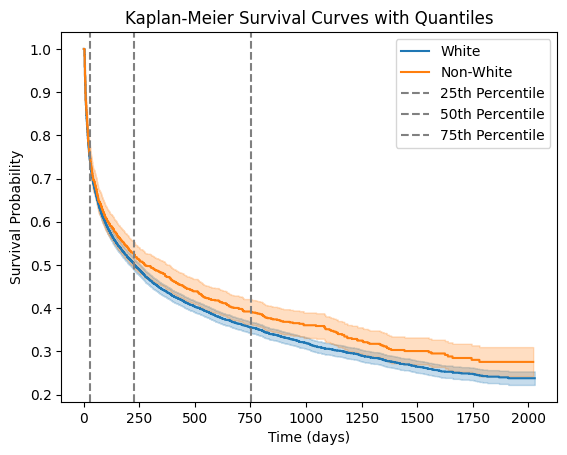

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np

# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Plot for the majority group (White)
kmf.fit(durations=y_tr['time'], event_observed=y_tr['event'])  # Adjust column names if different
kmf.plot(label='White')

# Plot for other demographics (Non-White)
kmf.fit(durations=y_tr_non_white['time'], event_observed=y_tr_non_white['event'])  # Adjust column names
kmf.plot(label='Non-White')

# Calculate and add vertical lines for the 25th, 50th, and 75th quantiles
percentiles = [25, 50, 75]
for p in percentiles:
    quantile = np.percentile(y_tr['time'], p)  # Adjust 'time' column based on dataset
    plt.axvline(x=quantile, color='gray', linestyle='--', label=f'{p}th Percentile')

# Customize plot
plt.title('Kaplan-Meier Survival Curves with Quantiles')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

In [ ]:
import numpy as np
print(outcomes.time[outcomes.event==1])

1         4
2        47
3       133
5         4
6       659
       ... 
9093     14
9095    295
9098     17
9103      7
9104    198
Name: time, Length: 6201, dtype: int64


In [ ]:
times = np.quantile(y_tr.time, [0.25, 0.5, 0.75]).tolist()
print(y_tr.time)

6977     919
5392      19
8022    1734
7700     386
4276       7
        ... 
6189    1747
5040       4
60      1992
8081       9
4633     906
Name: time, Length: 5463, dtype: int64


In [ ]:
import numpy as np
from auton_survival.experiments import SurvivalRegressionCV

param_grid = {'l2' : [1e-3, 1e-2,1e-1]}

#times = np.quantile(y_tr.time[y_tr.event==1], [0.25, 0.5, 0.75]).tolist()
cph_experiment = SurvivalRegressionCV(model='cph', num_folds=5, hyperparam_grid=param_grid, random_seed=7)
cph_model = cph_experiment.fit(x_tr.astype(np.float64), y_tr.astype(np.float64), times, metric='brs')

#times = np.quantile(y_tr_non_white.time[y_tr_non_white.event==1], [0.25, 0.5, 0.75]).tolist()
cph_non_white_experiment = SurvivalRegressionCV(model='cph', num_folds=5, hyperparam_grid=param_grid, random_seed=7)
cph_non_white_model = cph_non_white_experiment.fit(x_tr_non_white.astype(np.float64), y_tr_non_white.astype(np.float64), times, metric='brs')

At hyper-param {'l2': 0.001}
At fold: 0
At fold: 1
At fold: 2
At fold: 3
At fold: 4
At hyper-param {'l2': 0.01}
At fold: 0
At fold: 1
At fold: 2
At fold: 3
At fold: 4
At hyper-param {'l2': 0.1}
At fold: 0
At fold: 1
At fold: 2
At fold: 3
At fold: 4
At hyper-param {'l2': 0.001}
At fold: 0
At fold: 1
At fold: 2
At fold: 3
At fold: 4
At hyper-param {'l2': 0.01}
At fold: 0
At fold: 1
At fold: 2
At fold: 3
At fold: 4
At hyper-param {'l2': 0.1}
At fold: 0
At fold: 1
At fold: 2
At fold: 3
At fold: 4


In [ ]:
import numpy as np
from auton_survival.experiments import SurvivalRegressionCV


param_grid = {
    'k': [3, 4, 6],  # Number of mixture components K
    'layers': [[50, 100]],  # Units in each hidden layer
    'batch_size': [128],  # Mini-batch size (fixed)
    'lr': [1e-3],  # Learning rate (fixed)
}
#param_grid = {
#    'k': [4, 6, 8],                  # 论文验证4-6个组件效果最佳
#    'layers': [[100, 50], [200, 100]], # 更深的网络结构
#    'lr': [5e-4, 1e-4],              # 稳定训练的学习率范围
#    'batch_size': [32, 64],          # 较小batch增强梯度多样性
    #'iters': [500, 1000],            # Longer training for convergence
    #'optimizer': ['adam', 'rmsprop'] # Adam usually works best
#}
#times = np.quantile(y_tr.time[y_tr.event==1], [0.25, 0.5, 0.75]).tolist()
dcm_experiment = SurvivalRegressionCV(model='dcm', num_folds=5, hyperparam_grid=param_grid, random_seed=7)
dcm_model = dcm_experiment.fit(x_tr.astype(np.float64), y_tr.astype(np.float64), times, metric='brs')

#times = np.quantile(y_tr_non_white.time[y_tr_non_white.event==1], [0.25, 0.5, 0.75]).tolist()
dcm_non_white_experiment = SurvivalRegressionCV(model='dcm', num_folds=5, hyperparam_grid=param_grid, random_seed=7)
dcm_non_white_model = dcm_non_white_experiment.fit(x_tr_non_white.astype(np.float64), y_tr_non_white.astype(np.float64), times, metric='brs')

At hyper-param {'batch_size': 128, 'k': 3, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:18<00:00,  2.69it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:18<00:00,  2.77it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


 62%|██████▏   | 31/50 [00:11<00:06,  2.78it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 128, 'k': 4, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


100%|██████████| 50/50 [00:19<00:00,  2.51it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:19<00:00,  2.54it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:20<00:00,  2.48it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:20<00:00,  2.43it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


100%|██████████| 50/50 [00:20<00:00,  2.48it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At hyper-param {'batch_size': 128, 'k': 6, 'layers': [50, 100], 'lr': 0.001}
At fold: 0


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 1


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 2


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 3


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


At fold: 4


 98%|█████████▊| 49/50 [00:24<00:00,  1.97it/s]
/content/revisit-deepcoxmixtures-cs598-uiuc/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values
 54%|█████▍    | 27/50 [00:15<00:13,  1.74it/s]

In [ ]:
from auton_survival.models.dcm.dcm_utilities import predict_latent_z

latent_z_prob = dcm_model._model.predict_latent_z(x_tr.values.astype(np.float64))

# Let's look at the latent group probabilities
print(latent_z_prob)

# Let's look at the phenotypes
phenotypes = np.argmax(latent_z_prob, axis=1)
print(phenotypes)

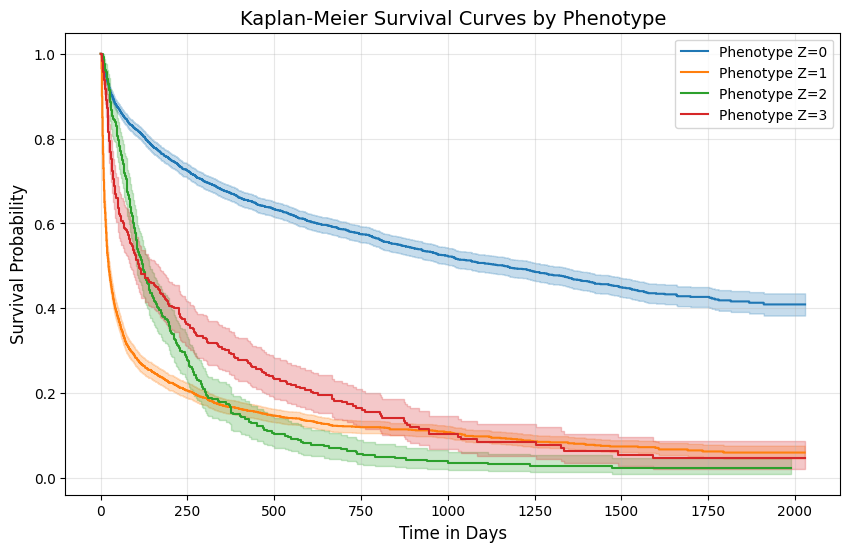

In [ ]:
outcomes_tr = outcomes.loc[x_tr.index]  # Ensure outcomes are aligned with x_tr
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

# Filter outcomes to match the shape of x_tr
outcomes_tr = outcomes.loc[x_tr.index]  # Align outcomes with x_tr

unique_phenotypes = np.unique(phenotypes)
for phenotype in unique_phenotypes:
    mask = phenotypes == phenotype

    # Use outcomes aligned with x_tr
    times = outcomes_tr['time'][mask]
    events = outcomes_tr['event'][mask]

    kmf.fit(times, event_observed=events, label=f"Phenotype Z={phenotype}")
    kmf.plot_survival_function()

# Add title and labels
plt.title("Kaplan-Meier Survival Curves by Phenotype", fontsize=14)
plt.xlabel("Time in Days", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)

# Add legend and grid
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.show()

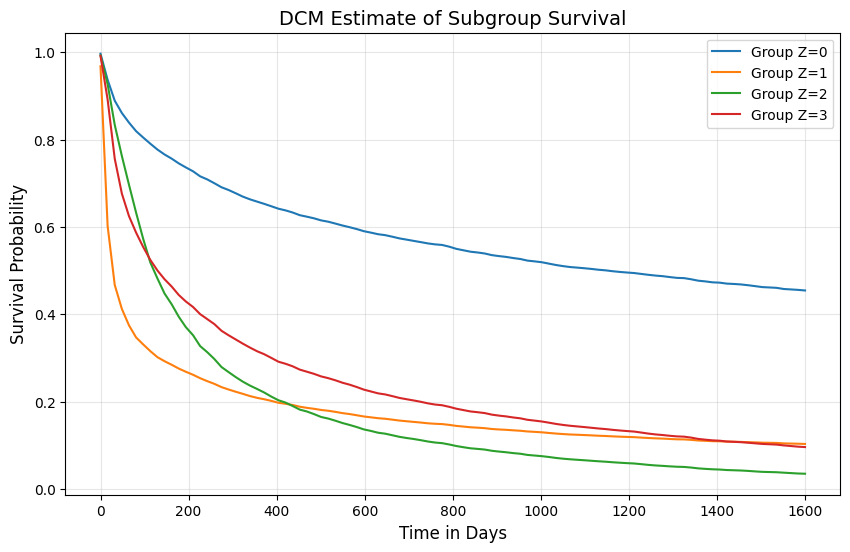

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a grid of time points for survival probability estimation
times = np.linspace(0, 1600, 100)  # Adjust the range based on your dataset

# Initialize a dictionary to store survival probabilities for each latent group
dcm_group_survival = {}

# Loop through each latent group
for group in range(latent_z_prob.shape[1]):  # Number of latent groups
    group_mask = phenotypes == group  # Mask individuals in the current group
    group_data = x_tr[group_mask]  # Subset data for the current group

    if len(group_data) == 0:
        # Skip if no individuals are in the group
        print(f"No data available for Group Z={group}. Skipping...")
        continue

    # Predict survival probabilities for each time point
    survival_probs = []
    for t in times:  # Loop through each time point
        # Compute survival probabilities for the current time point
        prob_t = dcm_model._model.predict_survival(group_data.values.astype(np.float64), [t])
        survival_probs.append(prob_t)

    # Convert list to array and average across individuals
    survival_probs = np.array(survival_probs).squeeze().T  # Transpose to match dimensions
    dcm_group_survival[group] = np.mean(survival_probs, axis=0)  # Average survival across individuals

# Plot survival curves
plt.figure(figsize=(10, 6))
for group, survival_curve in dcm_group_survival.items():
    plt.plot(times, survival_curve, label=f"Group Z={group}")

# Add plot title, axis labels, and legend
plt.title("DCM Estimate of Subgroup Survival", fontsize=14)
plt.xlabel("Time in Days", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.legend(loc="best")
plt.grid(alpha=0.3)

# Display the plot
plt.show()

In [ ]:
print(len(dcm_experiment.folds))
dcm_model
print(len(dcm_non_white_experiment.folds))
dcm_non_white_model

5463
1148


In [ ]:
times = np.quantile(y_tr.time, [0.25, 0.5, 0.75]).tolist()

param_grid = {'k' : [3, 4],
              'distribution' : ['Weibull'],
              'lr' : [1e-4, 1e-3],
              'batch_size': [128,256],  # Mini-batch size (fixed)
              'layers' : [[50,100]]}
#No. of Hidden Layers { ‘0’, ‘1’, ‘2’ }
#Activation { ‘SeLU’ }

#times = np.quantile(y_tr.time[y_tr.event==1], [0.25, 0.5, 0.75]).tolist()
dsm_experiment = SurvivalRegressionCV(model='dsm', num_folds=5, hyperparam_grid=param_grid, random_seed=0)
dsm_model = dsm_experiment.fit(x_tr.astype(np.float64), y_tr.astype(np.float64), times, metric='brs')

#times = np.quantile(y_tr_non_white.time[y_tr_non_white.event==1], [0.25, 0.5, 0.75]).tolist()
dsm_non_white_experiment = SurvivalRegressionCV(model='dsm', num_folds=5, hyperparam_grid=param_grid, random_seed=0)
dsm_non_white_model = dsm_non_white_experiment.fit(x_tr_non_white.astype(np.float64), y_tr_non_white.astype(np.float64), times, metric='brs')

In [ ]:
print(len(dsm_experiment.folds))
dsm_model
print(len(dsm_non_white_experiment.folds))

dsm_non_white_model

In [ ]:
#/auton_survival/estimators.py #470
#def _predict_rsf(model, features, times):
#  if isinstance(times, (int, float)):
#    times = [float(times)]
#
#  survival_predictions = model.predict_survival_function(features.values, return_array=True)
#  event_times = model.event_times_ if hasattr(model, 'event_times_') else model.unique_times_
#
#  survival_predictions = pd.DataFrame(survival_predictions, columns=event_times).T
#
#  return __interpolate_missing_times(survival_predictions, times)


# Define parameters for tuning the model
param_grid = {'n_estimators' : [150, 200, 250],
              'max_depth' : [5],
              'max_features' : ['sqrt']
             }

#No. of Trees {‘50’}

#times = np.quantile(y_tr.time[y_tr.event==1], [0.25, 0.5, 0.75]).tolist()
rsf_experiment = SurvivalRegressionCV(model='rsf', num_folds=5, hyperparam_grid=param_grid, random_seed=8)
rsf_model = rsf_experiment.fit(x_tr.astype(np.float64), y_tr.astype(np.float64), times, metric='brs')

#times = np.quantile(y_tr_non_white.time[y_tr_non_white.event==1], [0.25, 0.5, 0.75]).tolist()
rsf_non_white_experiment = SurvivalRegressionCV(model='rsf', num_folds=5, hyperparam_grid=param_grid, random_seed=8)
rsf_non_white_model = rsf_non_white_experiment.fit(x_tr_non_white.astype(np.float64), y_tr_non_white.astype(np.float64), times, metric='brs')

In [ ]:
print(len(rsf_experiment.folds))
rsf_model
print(len(rsf_non_white_experiment.folds))
rsf_non_white_model

In [ ]:
#def survival_regression_metric(metric, outcomes, predictions, times,
#                              outcomes_train=None, n_bootstrap=None):
#    if isinstance(times, (float,int)):
#        times = [times]

#    if outcomes_train is None:
#        outcomes_train = outcomes
#        warnings.warn("You are are evaluating model performance on the \
#same data used to estimate the censoring distribution.")

#    assert max(times) < outcomes_train.time.max(), "Times should \
#be within the range of event times to avoid exterpolation."
#    assert max(times) <= outcomes.time.max(), "Times \
#must be within the range of event times."

#    survival_train = util.Surv.from_dataframe('event', 'time', outcomes_train)
#    survival_test = util.Surv.from_dataframe('event', 'time', outcomes)

#    if metric == 'brs':
#        _metric = _brier_score
#    elif metric == 'ibs':
#        _metric = _integrated_brier_score
#    elif metric == 'auc':
#        _metric = _cumulative_dynamic_auc
#    elif metric == 'ctd':
#        _metric = _concordance_index_ipcw
#    elif metric == 'ece':
#        _metric = _expected_calibration_error
#    else:
#        raise NotImplementedError()

#    if n_bootstrap is None:
#        return _metric(survival_train, survival_test, predictions, times)
#    else:
#        return [_metric(survival_train, survival_test, predictions, times, random_seed=i) for i in range(n_bootstrap)]

#def _expected_calibration_error(survival_train, survival_test, predictions, times, n_bins=10, random_seed=None):
#    """
#    Compute Expected Calibration Error (ECE) for survival predictions at given times.

#    Args:
#        survival_train: Survival data for training (used for IPCW weights)
#        survival_test: Survival data for testing
#        predictions: Predicted survival probabilities (n_samples, n_times)
#        times: Time points at which to evaluate ECE
#        n_bins: Number of bins to use for risk score partitioning
#        random_seed: Random seed for reproducibility

#    Returns:
#        Dictionary with ECE values for each time point
#    """
#    if random_seed is not None:
#        np.random.seed(random_seed)

    # Get event indicators and times from test data
#    events = survival_test['event']
#    observed_times = survival_test['time']

    # Initialize results
#    ece_results = {}

#    for i, t in enumerate(times):
#        # Get predicted probabilities for this time point
#        pred_probs = predictions[:, i]

        # Create bins based on quantiles of predicted probabilities
#        bins = np.quantile(pred_probs, np.linspace(0, 1, n_bins + 1))
#        bin_indices = np.digitize(pred_probs, bins) - 1

        # Compute observed and expected probabilities in each bin
#        bin_observed = np.zeros(n_bins)
#        bin_expected = np.zeros(n_bins)
#        bin_weights = np.zeros(n_bins)

#        for j in range(n_bins):
#            mask = bin_indices == j
#            if np.sum(mask) == 0:
#                continue

            # Expected probability is the mean predicted probability in the bin
#            bin_expected[j] = np.mean(pred_probs[mask])

            # Compute observed survival using Kaplan-Meier within the bin
#            km = KaplanMeierFitter()
#            km.fit(observed_times[mask], events[mask])
#            bin_observed[j] = km.predict(t)

            # Weight by number of samples in the bin
#            bin_weights[j] = np.sum(mask)

        # Normalize weights
#        bin_weights = bin_weights / np.sum(bin_weights)

        # Compute weighted absolute differences
#        ece = np.sum(bin_weights * np.abs(bin_observed - bin_expected))
#        ece_results[t] = ece

#    return ece_results

In [ ]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
from auton_survival.metrics import survival_regression_metric

import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec


def plot_performance_metrics(results, times):
  colors = ['blue', 'purple', 'orange', 'green', 'black']
  gs = gridspec.GridSpec(1, len(results), wspace=1)
  for fi, result in enumerate(results.keys()):
    val = results[result]
    x = [str(round(t, 1)) for t in times]
    ax = plt.subplot(gs[0, fi]) # row 0, col 0
    ax.set_xlabel('Time')
    ax.set_ylabel(result)
    ax.set_ylim(0, 1)
    ax.bar(x, val, color=colors[fi])
    plt.xticks(rotation=30)
  plt.show()

def print_performance_metrics(array):
    max_val = np.max(array)  # Use numpy functions for array operations
    min_val = np.min(array)
    difference = max_val - min_val
    median = np.median(array)  # Calculate the median using numpy
    print(array)
def plot_auc(auc_values, times):
    plt.figure(figsize=(8, 6))
    plt.plot(times, auc_values, marker='o', color='blue', label='AUC')
    plt.xlabel('Time')
    plt.ylabel('Area Under Curve')
    plt.title('Area Under Curve Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

times = np.quantile(y_te.time, [0.25, 0.5, 0.75]).tolist()
y_te_non_white_times = np.quantile(y_te_non_white.time, [0.25, 0.5, 0.75]).tolist()
print(times)
print(y_te_non_white_times)

In [ ]:
cph_predictions_te = cph_model.predict_survival(x_te.astype(np.float64), times)
cph_results = dict()
cph_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te, predictions=cph_predictions_te,times=times, outcomes_train=y_tr)
cph_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=cph_predictions_te,times=times, outcomes_train=y_tr)
cph_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=cph_predictions_te,times=times, outcomes_train=y_tr)
cph_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te, predictions=cph_predictions_te,times=times, outcomes_train=y_tr)
cph_results['Expected L1 Calibration Error'] = np.array(list(survival_regression_metric('ece', outcomes=y_te, predictions=cph_predictions_te, times=times, outcomes_train=y_tr).values()))

plot_performance_metrics(cph_results, times)
print_performance_metrics(cph_results['Area Under Curve'])
print_performance_metrics(cph_results['Concordance Index'])
print_performance_metrics(cph_results['Expected L1 Calibration Error'])
plot_auc(cph_results['Area Under Curve'], times)

cph_non_white_predictions_te = cph_non_white_model.predict_survival(x_te_non_white.astype(np.float64), y_te_non_white_times)
cph_non_white_results = dict()
cph_non_white_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te_non_white, predictions=cph_non_white_predictions_te,times=y_te_non_white_times, outcomes_train=y_tr_non_white)
cph_non_white_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te_non_white, predictions=cph_non_white_predictions_te,times=y_te_non_white_times, outcomes_train=y_tr_non_white)
cph_non_white_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te_non_white, predictions=cph_non_white_predictions_te,times=y_te_non_white_times, outcomes_train=y_tr_non_white)
cph_non_white_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te_non_white, predictions=cph_non_white_predictions_te,times=y_te_non_white_times, outcomes_train=y_tr_non_white)
cph_non_white_results['Expected L1 Calibration Error'] = np.array([survival_regression_metric('ece', outcomes=y_te_non_white, predictions=cph_non_white_predictions_te, times=times, outcomes_train=y_tr_non_white)[t] for t in times])

plot_performance_metrics(cph_non_white_results, y_te_non_white_times)
print_performance_metrics(cph_non_white_results['Area Under Curve'])
print_performance_metrics(cph_non_white_results['Concordance Index'])
print_performance_metrics(cph_non_white_results['Expected L1 Calibration Error'])
plot_auc(cph_non_white_results['Area Under Curve'], y_te_non_white_times)

In [ ]:
dcm_predictions_te = dcm_model.predict_survival(x_te.astype(np.float64), times)
dcm_results = dict()
dcm_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te, predictions=dcm_predictions_te,times=times, outcomes_train=y_tr)
dcm_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=dcm_predictions_te,times=times, outcomes_train=y_tr)
dcm_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=dcm_predictions_te,times=times, outcomes_train=y_tr)
dcm_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te, predictions=dcm_predictions_te,times=times, outcomes_train=y_tr)
dcm_results['Expected L1 Calibration Error'] = np.array(list(survival_regression_metric('ece', outcomes=y_te, predictions=dcm_predictions_te, times=times, outcomes_train=y_tr).values()))

plot_performance_metrics(dcm_results, times)
print_performance_metrics(dcm_results['Area Under Curve'])
print_performance_metrics(dcm_results['Concordance Index'])
print_performance_metrics(dcm_results['Expected L1 Calibration Error'])
plot_auc(dcm_results['Area Under Curve'], times)

dcm_non_white_predictions_te = dcm_non_white_model.predict_survival(x_te_non_white.astype(np.float64), y_te_non_white_times)
dcm_non_white_results = dict()
dcm_non_white_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te_non_white, predictions=dcm_non_white_predictions_te,times=y_te_non_white_times, outcomes_train=y_tr_non_white)
dcm_non_white_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te_non_white, predictions=dcm_non_white_predictions_te,times=y_te_non_white_times, outcomes_train=y_tr_non_white)
dcm_non_white_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te_non_white, predictions=dcm_non_white_predictions_te,times=y_te_non_white_times, outcomes_train=y_tr_non_white)
dcm_non_white_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te_non_white, predictions=dcm_non_white_predictions_te,times=y_te_non_white_times, outcomes_train=y_tr_non_white)
dcm_non_white_results['Expected L1 Calibration Error'] = np.array(list( survival_regression_metric('ece', outcomes=y_te_non_white, predictions=dcm_non_white_predictions_te,times=times, outcomes_train=y_tr_non_white).values() ))

plot_performance_metrics(dcm_non_white_results, y_te_non_white_times)
print_performance_metrics(dcm_non_white_results['Area Under Curve'])
print_performance_metrics(dcm_non_white_results['Concordance Index'])
print_performance_metrics(dcm_non_white_results['Expected L1 Calibration Error'])
plot_auc(dcm_non_white_results['Area Under Curve'], y_te_non_white_times)


dsm_predictions_te = dsm_model.predict_survival(x_te.astype(np.float64), times)
dsm_results = dict()
dsm_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te, predictions=dsm_predictions_te,times=times, outcomes_train=y_tr)
dsm_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=dsm_predictions_te,times=times, outcomes_train=y_tr)
dsm_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=dsm_predictions_te,times=times, outcomes_train=y_tr)
dsm_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te, predictions=dsm_predictions_te,times=times, outcomes_train=y_tr)
dsm_results['Expected L1 Calibration Error'] = np.array(list( survival_regression_metric('ece', outcomes=y_te, predictions=dsm_predictions_te,times=times, outcomes_train=y_tr).values() ))

plot_performance_metrics(dsm_results, times)
print_performance_metrics(dsm_results['Area Under Curve'])
print_performance_metrics(dsm_results['Concordance Index'])
print_performance_metrics(dsm_results['Expected L1 Calibration Error'])
plot_auc(dsm_results['Area Under Curve'], times)

dsm_non_white_predictions_te = dsm_non_white_model.predict_survival(x_te_non_white.astype(np.float64), y_te_non_white_times)
dsm_non_white_results = dict()
dsm_non_white_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te_non_white, predictions=dsm_non_white_predictions_te,times=y_te_non_white_times, outcomes_train=y_tr_non_white)
dsm_non_white_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te_non_white, predictions=dsm_non_white_predictions_te,times=y_te_non_white_times, outcomes_train=y_tr_non_white)
dsm_non_white_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te_non_white, predictions=dsm_non_white_predictions_te,times=y_te_non_white_times, outcomes_train=y_tr_non_white)
dsm_non_white_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te_non_white, predictions=dsm_non_white_predictions_te,times=y_te_non_white_times, outcomes_train=y_tr_non_white)
dsm_non_white_results['Expected L1 Calibration Error'] = np.array(list( survival_regression_metric('ece', outcomes=y_te_non_white, predictions=dsm_non_white_predictions_te,times=times, outcomes_train=y_tr_non_white) .values() ))

plot_performance_metrics(dsm_non_white_results, y_te_non_white_times)
print_performance_metrics(dsm_non_white_results['Area Under Curve'])
print_performance_metrics(dsm_non_white_results['Concordance Index'])
print_performance_metrics(dsm_non_white_results['Expected L1 Calibration Error'])
plot_auc(dsm_non_white_results['Area Under Curve'], y_te_non_white_times)



In [ ]:
#times = np.quantile(y_tr.time[y_tr.event==1], [0.25, 0.5, 0.75]).tolist()
rsf_predictions_te = rsf_model.predict_survival(x_te.astype(np.float64), times)
rsf_results = dict()
rsf_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te, predictions=rsf_predictions_te,times=times, outcomes_train=y_tr)
rsf_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=rsf_predictions_te,times=times, outcomes_train=y_tr)
rsf_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=rsf_predictions_te,times=times, outcomes_train=y_tr)
rsf_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te, predictions=rsf_predictions_te,times=times, outcomes_train=y_tr)
rsf_results['Expected L1 Calibration Error'] = np.array(list( survival_regression_metric('ece', outcomes=y_te, predictions=rsf_predictions_te,times=times, outcomes_train=y_tr).values() ))

plot_performance_metrics(rsf_results, times)
print_performance_metrics(rsf_results['Area Under Curve'])
print_performance_metrics(rsf_results['Concordance Index'])
print_performance_metrics(rsf_results['Expected L1 Calibration Error'])
plot_auc(rsf_results['Area Under Curve'], times)

#times = np.quantile(y_tr_non_white.time[y_tr_non_white.event==1], [0.25, 0.5, 0.75]).tolist()
rsf_non_white_predictions_te = rsf_non_white_model.predict_survival(x_te_non_white.astype(np.float64), times)
rsf_non_white_results = dict()
rsf_non_white_results['Integrated Brier Score'] = survival_regression_metric('ibs', outcomes=y_te_non_white, predictions=rsf_non_white_predictions_te,times=times, outcomes_train=y_tr_non_white)
rsf_non_white_results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te_non_white, predictions=rsf_non_white_predictions_te,times=times, outcomes_train=y_tr_non_white)
rsf_non_white_results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te_non_white, predictions=rsf_non_white_predictions_te,times=times, outcomes_train=y_tr_non_white)
rsf_non_white_results['Area Under Curve'] = survival_regression_metric('auc', outcomes=y_te_non_white, predictions=rsf_non_white_predictions_te,times=times, outcomes_train=y_tr_non_white)
rsf_non_white_results['Expected L1 Calibration Error'] = np.array(list( survival_regression_metric('ece', outcomes=y_te_non_white, predictions=rsf_non_white_predictions_te,times=times, outcomes_train=y_tr_non_white).values() ))

plot_performance_metrics(rsf_non_white_results, times)
print_performance_metrics(rsf_non_white_results['Area Under Curve'])
print_performance_metrics(rsf_non_white_results['Concordance Index'])
print_performance_metrics(rsf_non_white_results['Expected L1 Calibration Error'])
plot_auc(rsf_non_white_results['Area Under Curve'], times)


In [ ]:
# Create a dictionary to store all results
results_summary = {
    'Model': ['CPH', 'CPH (Non-White)', 'DCM', 'DCM (Non-White)',
              'DSM', 'DSM (Non-White)', 'RSF', 'RSF (Non-White)'],
    'AUC': [
        cph_results['Area Under Curve'],
        cph_non_white_results['Area Under Curve'],
        dcm_results['Area Under Curve'],
        dcm_non_white_results['Area Under Curve'],
        dsm_results['Area Under Curve'],
        dsm_non_white_results['Area Under Curve'],
        rsf_results['Area Under Curve'],
        rsf_non_white_results['Area Under Curve']
    ],
    'CTD': [
        cph_results['Concordance Index'],
        cph_non_white_results['Concordance Index'],
        dcm_results['Concordance Index'],
        dcm_non_white_results['Concordance Index'],
        dsm_results['Concordance Index'],
        dsm_non_white_results['Concordance Index'],
        rsf_results['Concordance Index'],
        rsf_non_white_results['Concordance Index']
    ],
    'ECE': [
        cph_results['Expected L1 Calibration Error'],
        cph_non_white_results['Expected L1 Calibration Error'],
        dcm_results['Expected L1 Calibration Error'],
        dcm_non_white_results['Expected L1 Calibration Error'],
        dsm_results['Expected L1 Calibration Error'],
        dsm_non_white_results['Expected L1 Calibration Error'],
        rsf_results['Expected L1 Calibration Error'],
        rsf_non_white_results['Expected L1 Calibration Error']
    ],
    'Brier': [
        cph_results.get('Brier Score', np.nan),
        cph_non_white_results.get('Brier Score', np.nan),
        dcm_results.get('Brier Score', np.nan),
        dcm_non_white_results.get('Brier Score', np.nan),
        dsm_results.get('Brier Score', np.nan),
        dsm_non_white_results.get('Brier Score', np.nan),
        rsf_results.get('Brier Score', np.nan),
        rsf_non_white_results.get('Brier Score', np.nan)
    ],
    'IBS': [
        cph_results.get('Integrated Brier Score', np.nan),
        cph_non_white_results.get('Integrated Brier Score', np.nan),
        dcm_results.get('Integrated Brier Score', np.nan),
        dcm_non_white_results.get('Integrated Brier Score', np.nan),
        dsm_results.get('Integrated Brier Score', np.nan),
        dsm_non_white_results.get('Integrated Brier Score', np.nan),
        rsf_results.get('Integrated Brier Score', np.nan),
        rsf_non_white_results.get('Integrated Brier Score', np.nan)
    ]
}

# Convert to DataFrame
results_df = pd.DataFrame(results_summary)

# Save to text file
with open('model_performance_results.txt', 'w') as f:
    f.write("Model Performance Results\n")
    f.write("=======================\n\n")
    f.write(results_df.to_string(index=False))

    # Add time quantiles information if available
    try:
        times = np.quantile(y_tr.time[y_tr.event==1], [0.25, 0.5, 0.75]).tolist()
        f.write("\n\nTime Quantiles for Evaluation:\n")
        f.write(f"25th percentile: {times[0]:.2f}\n")
        f.write(f"50th percentile (median): {times[1]:.2f}\n")
        f.write(f"75th percentile: {times[2]:.2f}\n")
    except:
        pass

print("Results saved to 'model_performance_results.txt'")

In [ ]:
print(results_summary)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results_summary to a DataFrame
data = {
    'Model': ['CPH', 'CPH (Non-White)', 'DCM', 'DCM (Non-White)', 'DSM', 'DSM (Non-White)', 'RSF', 'RSF (Non-White)'],
    'AUC': [x[2] for x in results_summary['AUC']],  # Use the 3rd value (index 2)
    'CTD': [x[2] for x in results_summary['CTD']],  # Use the 3rd value (index 2)
    'ECE': [x[2] for x in results_summary['ECE']],  # Use the 3rd value (index 2)
    'Brier': [x[2] for x in results_summary['Brier']],  # Use the 3rd value (index 2)
    'IBS': results_summary['IBS']  # IBS remains unchanged (single value per model)
}

df = pd.DataFrame(data)

# Create Subgroup column
df['Subgroup'] = df['Model'].apply(lambda x: 'Non-White' if '(Non-White)' in x else 'Overall')

# Clean Model names (remove " (Non-White)" suffix)
df['Model'] = df['Model'].apply(lambda x: x.split(' (')[0])

# Plotting
plt.figure(figsize=(15, 10))
sns.set_theme(style="whitegrid")

# AUC (using array[2])
plt.subplot(2, 3, 1)
sns.barplot(data=df, x='Model', y='AUC', hue='Subgroup',
            palette={'Overall': 'skyblue', 'Non-White': 'salmon'})
plt.title('AUC (Higher is better)')
plt.xticks(rotation=45)
plt.ylim(0.65, 0.85)

# CTD (using array[2])
plt.subplot(2, 3, 2)
sns.barplot(data=df, x='Model', y='CTD', hue='Subgroup',
            palette={'Overall': 'skyblue', 'Non-White': 'salmon'})
plt.title('CTD (Higher is better)')
plt.xticks(rotation=45)
plt.ylim(0.6, 0.8)

# ECE (using array[2])
plt.subplot(2, 3, 3)
sns.barplot(data=df, x='Model', y='ECE', hue='Subgroup',
            palette={'Overall': 'skyblue', 'Non-White': 'salmon'})
plt.title('ECE (Lower is better)')
plt.xticks(rotation=45)
plt.ylim(0, 0.15)

# Brier (using array[2])
plt.subplot(2, 3, 4)
sns.barplot(data=df, x='Model', y='Brier', hue='Subgroup',
            palette={'Overall': 'skyblue', 'Non-White': 'salmon'})
plt.title('Brier Score (Lower is better)')
plt.xticks(rotation=45)
plt.ylim(0.1, 0.25)

# IBS (unchanged)
plt.subplot(2, 3, 5)
sns.barplot(data=df, x='Model', y='IBS', hue='Subgroup',
            palette={'Overall': 'skyblue', 'Non-White': 'salmon'})
plt.title('IBS (Lower is better)')
plt.xticks(rotation=45)
plt.ylim(0.18, 0.22)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results_summary to a DataFrame with all time points
data = {
    'Model': ['CPH', 'CPH (Non-White)', 'DCM', 'DCM (Non-White)', 'DSM', 'DSM (Non-White)', 'RSF', 'RSF (Non-White)'],
    'AUC_t0': [x[0] for x in results_summary['AUC']],
    'AUC_t1': [x[1] for x in results_summary['AUC']],
    'AUC_t2': [x[2] for x in results_summary['AUC']],
    'CTD_t0': [x[0] for x in results_summary['CTD']],
    'CTD_t1': [x[1] for x in results_summary['CTD']],
    'CTD_t2': [x[2] for x in results_summary['CTD']],
    'ECE_t0': [x[0] for x in results_summary['ECE']],
    'ECE_t1': [x[1] for x in results_summary['ECE']],
    'ECE_t2': [x[2] for x in results_summary['ECE']],
    'Brier_t0': [x[0] for x in results_summary['Brier']],
    'Brier_t1': [x[1] for x in results_summary['Brier']],
    'Brier_t2': [x[2] for x in results_summary['Brier']],
    'IBS': results_summary['IBS']  # IBS remains unchanged (single value per model)
}

df = pd.DataFrame(data)

# Create Subgroup column
df['Subgroup'] = df['Model'].apply(lambda x: 'Non-White' if '(Non-White)' in x else 'White')

# Clean Model names (remove " (Non-White)" suffix)
df['Model'] = df['Model'].apply(lambda x: x.split(' (')[0])

# Melt the DataFrame for time-point analysis
df_melted = pd.melt(
    df,
    id_vars=['Model', 'Subgroup', 'IBS'],
    value_vars=['AUC_t0', 'AUC_t1', 'AUC_t2', 'CTD_t0', 'CTD_t1', 'CTD_t2',
                'ECE_t0', 'ECE_t1', 'ECE_t2', 'Brier_t0', 'Brier_t1', 'Brier_t2'],
    var_name='Metric_Time',
    value_name='Value'
)

# Split Metric_Time into Metric and Time
df_melted[['Metric', 'Time']] = df_melted['Metric_Time'].str.split('_', expand=True)
df_melted['Time'] = df_melted['Time'].str.replace('t', '').astype(int)

# Define metrics and their properties
metrics = {
    'AUC': {'title': 'AUC (Higher is better)', 'ylim': (0.65, 0.85)},
    'CTD': {'title': 'CTD (Higher is better)', 'ylim': (0.6, 0.8)},
    'ECE': {'title': 'ECE (Lower is better)', 'ylim': (0, 0.16)},
    'Brier': {'title': 'Brier Score (Lower is better)', 'ylim': (0.1, 0.25)},
    'IBS': {'title': 'IBS (Lower is better)', 'ylim': (0.18, 0.22)}
}

# Custom palette and legend labels
time_palette = ["#1E88E5", "#0D47A1", "#052F5F"]  # Dark blue to very dark blue (t0 → t2)
time_labels = ['25th quantile', '50th quantile', '75th quantile']  # New legend labels

# Create separate plots for White and Non-White subgroups
for subgroup in ['White', 'Non-White']:
    plt.figure(figsize=(20, 12))
    sns.set_theme(style="whitegrid")
    plt.suptitle(f'Model Performance Metrics ({subgroup} Subgroup)', y=1.02, fontsize=16)

    # Plot each metric in a separate subplot
    for i, (metric, props) in enumerate(metrics.items(), 1):
        plt.subplot(2, 3, i)
        if metric != 'IBS':
            ax = sns.barplot(
                data=df_melted[(df_melted['Metric'] == metric) & (df_melted['Subgroup'] == subgroup)],
                x='Model', y='Value', hue='Time',
                palette=time_palette,
                hue_order=[0, 1, 2],  # Ensure consistent ordering
                order=['CPH', 'DCM', 'DSM', 'RSF'],
                errorbar=None
            )
            plt.title(props['title'])
            plt.ylim(props['ylim'])
            plt.xticks(rotation=45)
            plt.xlabel('Model')
            plt.ylabel('Score')

            # Update legend with quantile labels
            handles, _ = ax.get_legend_handles_labels()
            ax.legend(handles, time_labels, title='Time Points', bbox_to_anchor=(1.02, 1), loc='upper left')

            # Add value annotations on top of bars
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.3f}",
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 5),
                           textcoords='offset points', fontsize=8)
        else:
            # IBS (single value per model)
            ax = sns.barplot(
                data=df[df['Subgroup'] == subgroup],
                x='Model', y='IBS',
                color='skyblue',
                order=['CPH', 'DCM', 'DSM', 'RSF'],
                errorbar=None
            )
            plt.title(props['title'])
            plt.ylim(props['ylim'])
            plt.xticks(rotation=45)

            # Add value annotations on top of bars
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.3f}",
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 5),
                           textcoords='offset points', fontsize=8)

    plt.tight_layout()
    plt.show()

In [ ]:
The performance degradation of Deep Cox Mixtures (DCM) at the 75th quantile reveals fundamental limitations in its parametric architecture. At this later time point, DCM shows significantly worse performance across all key metrics (AUC, CTD, ECE) compared to alternative models, indicating systematic challenges in handling long-term survival predictions. The root cause lies in DCM's reliance on a mixture of Cox models with two restrictive assumptions: proportional hazards within each component and fixed mixing proportions over time. While these assumptions work reasonably well for early events, they fail to adapt to the complex, time-varying risk patterns that emerge in longer follow-up periods.

The superior performance of Random Survival Forests (RSF) and Deep Survival Machines (DSM) at this quantile highlights the advantages of more flexible approaches. RSF's non-parametric nature and ensemble structure naturally adapt to changing hazards and capture complex interactions, while DSM's neural network architecture avoids strict proportional hazards assumptions and better models time-dependent relationships. DCM's increasing calibration error (ECE) at the 75th quantile further demonstrates how its fixed parameterization struggles with the changing censoring patterns and probability distributions of later time periods.

These limitations become particularly apparent when examining subgroup performance, where DCM shows worse results for "Non-White" populations. This suggests the model's mixture components may not adequately represent minority populations, likely due to training data imbalances affecting its parametric assumptions. The practical implications are significant, as clinical applications often prioritize accurate long-term predictions. While DCM offers valuable interpretability, practitioners must weigh this benefit against its declining predictive accuracy at later time points compared to more flexible alternatives like RSF and DSM.






In [ ]:
import time
import numpy as np
from auton_survival.experiments import SurvivalRegressionCV

# Define the hyperparameter grid
param_grid = {
    'k': [3, 4, 6],  # Number of mixture components K
    'layers': [[50, 100]],  # Units in each hidden layer
    'batch_size': [128],  # Mini-batch size (fixed)
    'lr': [1e-3],  # Learning rate (fixed)
}

# Initialize the experiment with 5 folds
dcm_experiment = SurvivalRegressionCV(model='dcm', num_folds=5, hyperparam_grid=param_grid, random_seed=7)

# Start timing the training process
start_time = time.time()

# Fit the model (replace x_tr and y_tr with your training dataset)
dcm_model = dcm_experiment.fit(x_tr.astype(np.float64), y_tr.astype(np.float64), times, metric='brs')

# End timing the training process
end_time = time.time()

# Calculate total running time
total_running_time = end_time - start_time

# Default number of epochs
epochs = 50

# Calculate average runtime per epoch
average_runtime_per_epoch = total_running_time / epochs

print(f"Total Running Time: {total_running_time:.2f} seconds")
print(f"Average Runtime per Epoch: {average_runtime_per_epoch:.2f} seconds")